# **Liver Medical Image Semantic Segmentation Using Pytorch**

---



Task 1: Environment Setup: Set up the development environment using Python + PyTorch.

In [2]:
# Importing necessary libraries and packages
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision.utils import save_image

In [3]:
# Setting device for use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


Task 2: Dataset download and preprocessing

In [4]:
images_dir = 'Liver_Medical_Image _Datasets/Images'
labels_dir = 'Liver_Medical_Image _Datasets/Labels'

In [5]:
# Custom Dataset for Liver Medical Image Segmentation
class LiverDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_filenames = sorted(os.listdir(images_dir))
        self.label_filenames = sorted(os.listdir(labels_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image and corresponding label
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        label_path = os.path.join(self.labels_dir, self.label_filenames[idx])

        image = Image.open(image_path).convert("L")  # Convert to grayscale
        label = Image.open(label_path).convert("L")  # Convert to grayscale

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        # Convert label to binary (0 for background, 1 for liver)
        label = torch.where(label > 0, 1, 0).float()
        return image, label

# Preprocessing and Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a consistent size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images (mean=0.5, std=0.5 for grayscale)
])

Task 3: Building the U-Net Architecture

In [6]:
# U-Net Model for Liver Medical Image Segmentation
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder (Contracting Path)
        self.encoder_block1 = self.conv_block(1, 64)
        self.encoder_block2 = self.conv_block(64, 128)
        self.encoder_block3 = self.conv_block(128, 256)
        self.encoder_block4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck_block = self.conv_block(512, 1024)

        # Decoder (Expansive Path)
        self.upconv_block4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder_block4 = self.conv_block(1024, 512)

        self.upconv_block3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder_block3 = self.conv_block(512, 256)

        self.upconv_block2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_block2 = self.conv_block(256, 128)

        self.upconv_block1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_block1 = self.conv_block(128, 64)

        # Output Layer
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_block1(x)
        enc2 = self.encoder_block2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder_block3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder_block4(F.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck_block(F.max_pool2d(enc4, 2))

        # Decoder
        dec4 = self.upconv_block4(bottleneck)
        dec4 = torch.cat((enc4, dec4), dim=1)
        dec4 = self.decoder_block4(dec4)

        dec3 = self.upconv_block3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.decoder_block3(dec3)

        dec2 = self.upconv_block2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder_block2(dec2)

        dec1 = self.upconv_block1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.decoder_block1(dec1)

        # Output Layer
        output = self.output_layer(dec1)
        output = torch.sigmoid(output)  # Sigmoid for binary segmentation

        return output

Task 4: Model Training

Epoch [1/5]: 100%|██████████| 23/23 [11:29<00:00, 29.96s/batch]


Epoch [1/5]: Train Loss: 0.3821, Train Accuracy: 92.40%, Val Loss: 0.4368, Val Accuracy: 92.90%


Epoch [2/5]: 100%|██████████| 23/23 [11:48<00:00, 30.79s/batch]


Epoch [2/5]: Train Loss: 0.2010, Train Accuracy: 98.58%, Val Loss: 0.1958, Val Accuracy: 97.99%


Epoch [3/5]: 100%|██████████| 23/23 [09:09<00:00, 23.91s/batch]


Epoch [3/5]: Train Loss: 0.1349, Train Accuracy: 98.95%, Val Loss: 0.1124, Val Accuracy: 99.13%


Epoch [4/5]: 100%|██████████| 23/23 [12:24<00:00, 32.35s/batch]


Epoch [4/5]: Train Loss: 0.0940, Train Accuracy: 99.23%, Val Loss: 0.0822, Val Accuracy: 99.31%


Epoch [5/5]: 100%|██████████| 23/23 [08:22<00:00, 21.84s/batch]


Epoch [5/5]: Train Loss: 0.0696, Train Accuracy: 99.37%, Val Loss: 0.0598, Val Accuracy: 99.45%


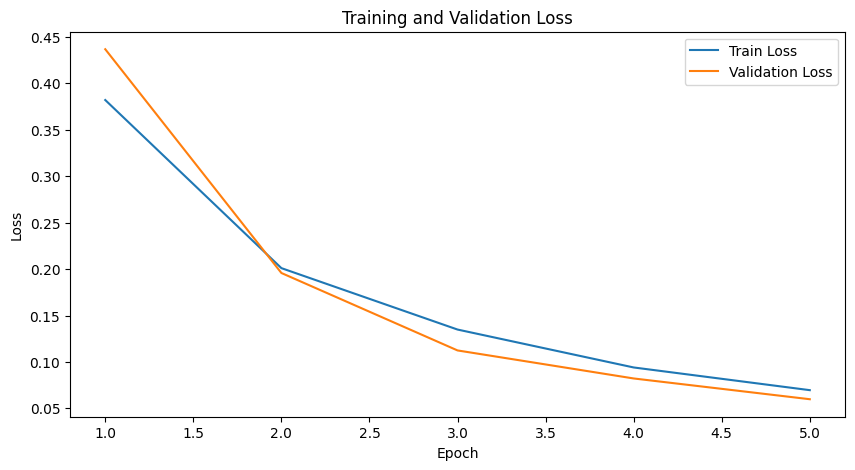

Training with validation completed!
Model saved as unet_model.pth


In [7]:
# Dataset Initialization
dataset = LiverDataset(images_dir, labels_dir, transform=transform)

# Create indices for splitting
num_images = len(dataset)
indices = list(range(num_images))

# Split indices into training and remainder (validation + test)
train_indices, remainder_indices = train_test_split(indices, train_size=360, random_state=42)

# Split remainder into validation and test
val_indices, test_indices = train_test_split(remainder_indices, test_size=0.5, random_state=42)

# Create subsets for training, validation, and testing
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Defining Hyperparameters
learning_rate = 0.001
num_epochs = 5

# Model, Loss Function, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store losses
train_losses = []
val_losses = []

# Training Loop with Validation
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    # Training Phase
    with tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as train_pbar:
        for images, labels in train_pbar:
            images = images.to(device)
            labels = labels.to(device)

            # Forward Pass
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.numel()

            # Compute Loss
            loss = criterion(outputs, labels)

            # Backward Pass and Optimization Step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_dataloader)
        train_accuracy = 100 * correct / total
        train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward Pass
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.numel()

            # Compute Loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)

    # Print the result in the desired format on the same line after epoch progress
    print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

print("Training with validation completed!")

# Save the model
torch.save(model.state_dict(), "unet_model.pth")
print("Model saved as unet_model.pth")

Task 5: Model Evaluation

In [8]:
# Model Evaluation on Test Set
model.eval()  # Set model to evaluation mode
intersection = 0
union = 0
pixel_correct = 0
total_pixels = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device).byte()

        # Forward Pass
        outputs = model(images)
        predicted = (outputs > 0.5).byte()

        # Ensure both tensors have the same shape
        predicted = predicted.view_as(labels)

        # Calculate Intersection and Union for mIoU
        intersection += (predicted & labels).sum().item()
        union += (predicted | labels).sum().item()

        # Calculate Pixel Accuracy
        pixel_correct += (predicted == labels).sum().item()
        total_pixels += labels.numel()

# Mean Intersection over Union (mIoU)
miou = intersection / (union + 1e-10)

# Mean Pixel Accuracy (mPA)
mpa = 100 * pixel_correct / total_pixels

print(f"Test Evaluation: mIoU: {miou:.4f}, mPA: {mpa:.2f}%")


Test Evaluation: mIoU: 0.9386, mPA: 99.45%


Task 6: Single Image Segmentation

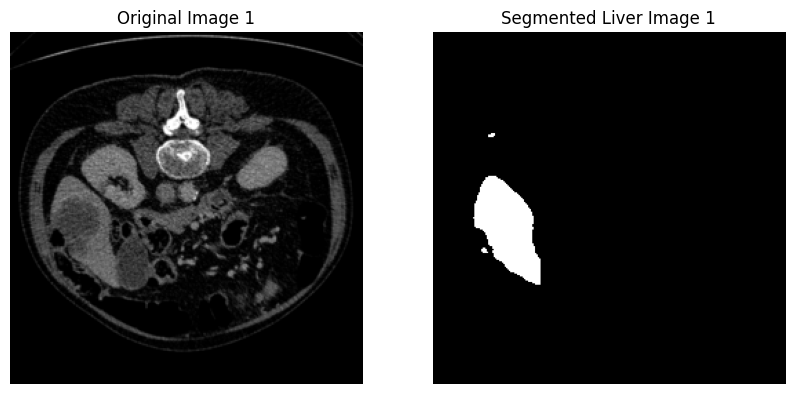

Segmented liver image saved as segmented_liver_image_1.png


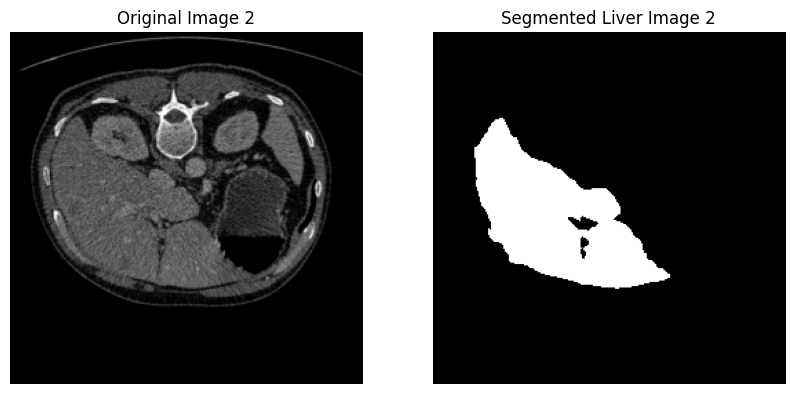

Segmented liver image saved as segmented_liver_image_2.png


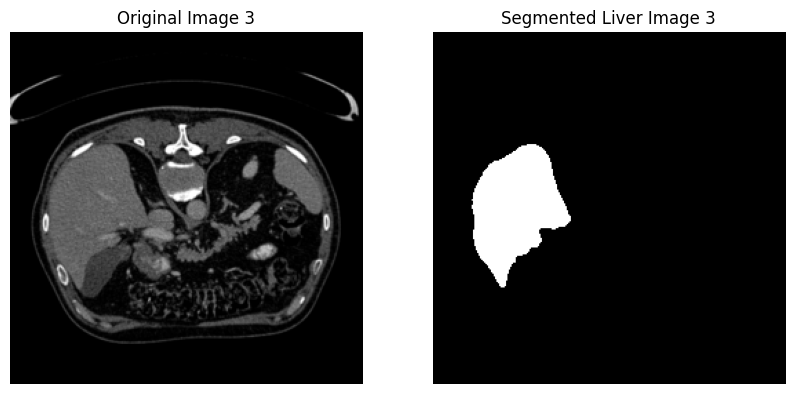

Segmented liver image saved as segmented_liver_image_3.png


In [9]:
model.eval() 
with torch.no_grad():
    # Iterate over the first three images from the test set
    for i in range(3):
        # Get a single image from the test set
        single_image, _ = test_dataset[i]  
        single_image = single_image.unsqueeze(0).to(device)  

        # Forward Pass
        output = model(single_image)
        predicted_mask = (output > 0.5).float().cpu()

        # Remove batch dimension
        predicted_mask = predicted_mask.squeeze(0)

        # Display the original image and segmented result side by side
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(single_image.squeeze().cpu().numpy(), cmap='gray')
        plt.title(f'Original Image {i+1}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title(f'Segmented Liver Image {i+1}')
        plt.axis('off')

        plt.show()

        # Save the segmented image
        save_image(predicted_mask, f"segmented_liver_image_{i+1}.png")
        print(f"Segmented liver image saved as segmented_liver_image_{i+1}.png")
